Importing Modules

In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import numpy as np
import argparse
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
import sys, importlib as impL
import pandas as pd
print("pandas: ", pd.__version__)
print("torch: ", torch.__version__)
print("numpy: ", np.__version__)

pandas:  0.23.4
torch:  1.4.0
numpy:  1.17.2


In [2]:
import socket
def get_var_by_comp_name(variableName):
    curCompName = socket.gethostname()
    retVal = None
    if variableName == 'khs_dir':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/home/wsubuntu/GitHub/keyhandshapediscovery'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'data_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/Datasets'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/media/wsubuntu/SSD_Data/DataPath'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'experiment_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery/experiments/SPARSE_TORCH'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/media/wsubuntu/SSD_Data/vaesae_experiments'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
        
    print(curCompName + '_' + variableName, '=',  retVal)
    if retVal is None:
        os.error(5)
    return retVal

khs_dir = get_var_by_comp_name('khs_dir')
data_path = get_var_by_comp_name('data_path')
experiment_path = get_var_by_comp_name('experiment_path')

doga-MSISSD_khs_dir = /mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery
doga-MSISSD_data_path = /mnt/USB_HDD_1TB/Datasets
doga-MSISSD_experiment_path = /mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery/experiments/SPARSE_TORCH


In [3]:
sys.path.insert(1, khs_dir)
import helperFuncs as funcH

/home/doga/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/doga/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/doga/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/doga/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [4]:
EXPERIMENT_ID = 18
LOSS_TYPE='cre'
LOSS_REDUCTION='mean' #'batchmean','sum'
SIGMOID_ACT=True
MSE_PLUS_MINUS='+'
APPLY_SPARSITY_TO='bottleneck' #all

In [5]:
def calc_bottleneck_acc(bottleneck_vec, lab_vec):
    pred_vec = np.argmax(bottleneck_vec.T, axis=0).T.squeeze()
    centroid_info_pdf = funcH.get_cluster_centroids(bottleneck_vec, pred_vec, kluster_centers=None, verbose=0)
    _confMat_preds, kluster2Classes, kr_pdf, weightedPurity, cnmxh_perc = funcH.countPredictionsForConfusionMat(lab_vec, pred_vec, centroid_info_pdf=centroid_info_pdf, labelNames=None)
    sampleCount = np.sum(np.sum(_confMat_preds))
    acc = 100 * np.sum(np.diag(_confMat_preds)) / sampleCount
    bmx, bmn = np.max(bottleneck_vec), np.min(bottleneck_vec)
    return acc, bmx, bmn

funcH.setPandasDisplayOpts()

Constructing the Argument Parsers

In [6]:
#ap = argparse.ArgumentParser()
#ap.add_argument('-e', '--epochs', type=int, default=10, help='number of epochs to train our network for')
#ap.add_argument('-l', '--reg_param', type=float, default=0.001, help='regularization parameter `lambda`')
#ap.add_argument('-sc', '--add_sparse', type=str, default='yes', help='whether to add sparsity contraint or not')
#args = vars(ap.parse_args())
epochs = 100  # args['epochs']
reg_param = 0.001  # args['reg_param']
add_sparsity = 'yes'  # args['add_sparse']
learning_rate = 1e-4
batch_size = 32
print(f"Add sparsity regularization: {add_sparsity}")

Add sparsity regularization: yes


here I will change the data loader per my need

In [7]:
# get the computation device
def get_device():
    return 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cuda:0


In [8]:
# image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

FOLDERS = {
    "data": data_path,
    "experiment": os.path.join(experiment_path, 'sparse_torch_ae_' + str(EXPERIMENT_ID).zfill(3)),
}
FOLDERS["model_save"] = os.path.join(FOLDERS["experiment"], "model")
FOLDERS["decoder_image_path_tr"] = os.path.join(FOLDERS["experiment"], "output_images_tr")
FOLDERS["decoder_image_path_va"] = os.path.join(FOLDERS["experiment"], "output_images_va")
funcH.createDirIfNotExist(FOLDERS["model_save"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_tr"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_va"])

trainset = datasets.FashionMNIST(
    root=FOLDERS["data"],
    train=True, 
    download=True,
    transform=transform
)
testset = datasets.FashionMNIST(
    root=FOLDERS["data"],
    train=False,
    download=True,
    transform=transform
)
 
# trainloader
trainloader = DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True
)
#testloader
testloader = DataLoader(
    testset, 
    batch_size=batch_size, 
    shuffle=False
)

In [9]:
# define the autoencoder model
class SparseAutoencoder(nn.Module):
    def __init__(self, loss_type):
        super(SparseAutoencoder, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=32)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=32, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
        
        self.loss_type=loss_type
        self.device = get_device()

    def encode(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        bottleneck = F.relu(self.enc5(x))  
        return bottleneck
        
    def decode(self, bottleneck):
        # decoding
        x = F.relu(self.dec1(bottleneck))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x)) 
        return x
        
    def forward(self, x):
        bottleneck = self.encode(x)
        x = self.decode(bottleneck)
        return x, bottleneck

model = SparseAutoencoder(loss_type=LOSS_TYPE).to(device)

In [10]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# get the layers as a list
model_children = list(model.children())
[print(i) for i in model_children]

Linear(in_features=784, out_features=256, bias=True)
Linear(in_features=256, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=32, bias=True)
Linear(in_features=32, out_features=32, bias=True)
Linear(in_features=32, out_features=64, bias=True)
Linear(in_features=64, out_features=128, bias=True)
Linear(in_features=128, out_features=256, bias=True)
Linear(in_features=256, out_features=784, bias=True)


[None, None, None, None, None, None, None, None, None, None]

In [12]:
def loss_l1(bottleneck):
    return torch.mean(torch.abs(bottleneck))

def loss_l2(bottleneck):
    return torch.mean(torch.pow(bottleneck, torch.tensor(2.0).to(device))).sqrt()

def kl_divergence(bottleneck, reduction):
    bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
    rho_val = 1/bt.size(1)
    rho_mat = torch.tensor([rho_val] * np.ones(bt.size()), dtype=torch.float32).to(device)
    #https://discuss.pytorch.org/t/kl-divergence-produces-negative-values/16791/13
    #KLDLoss(p, q), sum(q) needs to equal one
    #p = log_softmax(tensor)
    loss_ret_1 = F.kl_div(F.log_softmax(bt, dim=1).to(device), rho_mat, reduction=reduction)
    # torch.sum(rho * torch.log(rho / bottleneck) + (1 - rho) * torch.log((1 - rho) / (1 - bottleneck)))
    return loss_ret_1

def loss_crossentropy(bottleneck, sigmoidAct, reduction):
    loss_fun = torch.nn.CrossEntropyLoss(reduction=reduction)
    if sigmoidAct:
        bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
    else:
        bt = bottleneck    
    _, preds = torch.max(bt, 1)
    loss_ret_1 = loss_fun(F.log_softmax(bt, dim=1).to(device), preds)    
    return loss_ret_1

In [13]:
# define the sparse loss function
def sparse_loss(autoencoder, images, print_info, loss_type):
    loss = 0
    values = images
    for i in range(len(model_children)):
        values = F.relu((model_children[i](values)))
        #if print_info:
            #print(i, ' shape=', values.shape)
        if loss_type=='l1':
            loss += loss_l1(values)
        if loss_type=='l2':
            loss += loss_l2(values)
        if loss_type=='kl':
            loss += kl_divergence(values, reduction=LOSS_REDUCTION)
        if loss_type=='cre':
            loss += loss_crossentropy(values, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION)
        if print_info:
            print(loss_type,loss)
    return loss

def sparse_loss_bottleneck(bottleneck, print_info, loss_type):
    loss = 0
    #if print_info:
        #print(i, ' shape=', values.shape)
    if loss_type=='l1':
        loss += loss_l1(bottleneck)
    if loss_type=='l2':
        loss += loss_l2(bottleneck)
    if loss_type=='kl':
        loss += kl_divergence(bottleneck, reduction=LOSS_REDUCTION)
    if loss_type=='cre':
        loss += loss_crossentropy(bottleneck, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION)
    if print_info:
        print(loss_type,loss)
    return loss

In [14]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

# define the training function
def fit(model, dataloader, epoch, print_losses_fit):
    print('TrEpoch({:03d}) - '.format(epoch), end='')
    model.train()
    running_loss = 0.0
    
    lab_vec = []
    bottleneck_vec = []
    sparsity_loss_sum = 0
    mse_sum = 0
       
    for data in dataloader:
        img, lb = data
        lab_vec.append(lb)
        
        img = img.to(device)
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        outputs, bottleneck = model(img)
        bottleneck_vec.append(bottleneck)
        mse_loss = criterion(outputs, img)
        mse_sum += mse_loss.item()
        #if print_losses_fit:
            #print("mse_loss:", mse_loss.to('cpu'))
            #print("bottleneck:", bottleneck.to('cpu'))
        if add_sparsity == 'yes':
            if APPLY_SPARSITY_TO=='all':
                sp_loss = sparse_loss(model, img, print_losses_fit, model.loss_type)
            elif APPLY_SPARSITY_TO=='bottleneck': #all
                sp_loss = sparse_loss_bottleneck(bottleneck, print_losses_fit, model.loss_type)
            else:
                os.exit(4)
                
            sparsity_loss_sum += sp_loss.item()
            
            # add the sparsity penalty
            if print_losses_fit:
                print("sp_loss:", sparsity_loss_sum)
                
            if MSE_PLUS_MINUS=='-':
                loss = mse_loss - reg_param * sp_loss
            elif MSE_PLUS_MINUS=='+':
                loss = mse_loss + reg_param * sp_loss
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print_losses_fit = False
    
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec)
    #print("tr bottleneck accuracy=", acc, ", max=", bmx, ", min=", bmn, ", sparsity_loss_sum=", sparsity_loss_sum)
  
    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, mse_sum, sparsity_loss_sum, running_loss]]), columns=['acc','bmx','bmn','mse','spr','run'])
    #print(df.iloc[0]['mse']) #'acc','bmx','bmn','mse','spr','run'
    print("\n",result_df)
    if epoch % 2 == 0:
        difn = os.path.join(FOLDERS["decoder_image_path_tr"], "train"+str(epoch).zfill(3)+".png")
        save_decoded_image(outputs.cpu().data, difn)
    return result_df

In [15]:
# define the validation function
def validate(model, dataloader, epoch, print_losses_fit):
    print('ValEpoch({:03d}) - '.format(epoch), end='')
    model.eval()
    running_loss = 0.0
    lab_vec = []
    bottleneck_vec = []
    with torch.no_grad():
        for data in dataloader:
            img, lb = data
            lab_vec.append(lb)
            img = img.to(device)
            img = img.view(img.size(0), -1)
            outputs, bottleneck = model(img)
            bottleneck_vec.append(bottleneck)
            loss = criterion(outputs, img)
            running_loss += loss.item()
    # save the reconstructed images every 5 epochs
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec)

    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, running_loss]]), columns=['acc','bmx','bmn','run'])
    print("\n",result_df)
    
    if epoch % 2 == 0:
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        difn = os.path.join(FOLDERS["decoder_image_path_va"], "reconstruction"+str(epoch).zfill(3)+".png")
        save_image(outputs, difn)
    return result_df

In [16]:
# train and validate the autoencoder neural network
start = time.time()
print_losses_fit = True

train_loss = []
trn_spars_loss = []
trn_bot_acc = []
val_loss = []
val_bot_acc = []

result_df_tr_all = pd.DataFrame(columns=['acc','bmx','bmn','mse','spr','run'])
result_df_va_all = pd.DataFrame(columns=['acc','bmx','bmn','run'])

print("stae_dgmsissd :: ")
print("EXPERIMENT_ID: ", EXPERIMENT_ID)
print("LOSS_TYPE : ", LOSS_TYPE)
print("LOSS_REDUCTION : ", LOSS_REDUCTION)
print("SIGMOID_ACT : ", SIGMOID_ACT)
print("APPLY_SPARSITY_TO : ", APPLY_SPARSITY_TO)
print("total loss = mse_loss " + MSE_PLUS_MINUS + " reg_param * sp_loss")

for epoch in range(epochs):
    print(f"*****\n Epoch {epoch} of {epochs}")
    result_df_tr = fit(model, trainloader, epoch, print_losses_fit)
    result_df_va = validate(model, testloader, epoch, print_losses_fit)
    print_losses_fit = epoch%5==0 and epoch>0
    result_df_tr_all = result_df_tr_all.append(result_df_tr, ignore_index=True)
    result_df_va_all = result_df_va_all.append(result_df_va, ignore_index=True)
    
end = time.time()
 
print(f"{(end-start)/60:.3} minutes")
# save the trained model

mofn = os.path.join(FOLDERS["model_save"], "sparse_ae_"+str(epoch).zfill(3)+".pth")
torch.save(model.state_dict(), mofn)

stae_dgmsissd :: 
EXPERIMENT_ID:  18
LOSS_TYPE :  cre
LOSS_REDUCTION :  mean
SIGMOID_ACT :  True
APPLY_SPARSITY_TO :  bottleneck
total loss = mse_loss + reg_param * sp_loss
*****
 Epoch 0 of 100
TrEpoch(000) - cre tensor(3.4451, device='cuda:0', grad_fn=<AddBackward0>)
sp_loss: 3.445064067840576

       acc     bmx  bmn      mse       spr      run
0  10.432  32.708  0.0  140.234  6070.575  146.304
ValEpoch(000) - 
      acc     bmx  bmn    run
0  23.62  32.328  0.0  15.77
*****
 Epoch 1 of 100
TrEpoch(001) - 
       acc     bmx  bmn     mse       spr     run
0  23.237  37.237  0.0  85.382  6120.334  91.502
ValEpoch(001) - 
     acc     bmx  bmn     run
0  21.9  36.421  0.0  13.284
*****
 Epoch 2 of 100
TrEpoch(002) - 
       acc     bmx  bmn     mse       spr     run
0  21.215  37.713  0.0  76.519  6125.226  82.645
ValEpoch(002) - 
      acc     bmx  bmn     run
0  19.73  36.753  0.0  12.355
*****
 Epoch 3 of 100
TrEpoch(003) - 
       acc     bmx  bmn     mse       spr     run
0  18.3

KeyboardInterrupt: 

In [17]:
print(result_df_tr_all)

       acc     bmx  bmn      mse       spr      run
0   10.432  32.708  0.0  140.234  6070.575  146.304
1   23.237  37.237  0.0   85.382  6120.334   91.502
2   21.215  37.713  0.0   76.519  6125.226   82.645
3   18.328  37.907  0.0   72.842  6130.657   78.972
4   16.062  38.173  0.0   69.719  6136.639   75.856
5   19.307  39.575  0.0   65.642  6146.306   71.789
6   24.538  39.990  0.0   62.497  6141.361   68.638
7   23.423  40.093  0.0   61.278  6131.462   67.409
8   23.482  38.917  0.0   60.047  6125.717   66.172
9   23.515  37.949  0.0   59.176  6122.687   65.298
10  18.975  37.812  0.0   58.618  6120.754   64.738
11  16.498  36.642  0.0   58.167  6118.350   64.285
12  17.568  35.471  0.0   57.317  6115.424   63.432


In [18]:
print(result_df_va_all)

      acc     bmx  bmn     run
0   23.62  32.328  0.0  15.770
1   21.90  36.421  0.0  13.284
2   19.73  36.753  0.0  12.355
3   16.46  36.851  0.0  12.033
4   18.56  37.699  0.0  11.379
5   22.69  39.166  0.0  10.626
6   22.49  39.755  0.0  10.339
7   19.30  38.976  0.0  10.182
8   19.67  38.157  0.0   9.962
9   19.45  37.374  0.0   9.852
10  18.67  36.332  0.0   9.788
11  16.73  35.502  0.0   9.703
12  17.65  34.565  0.0   9.523


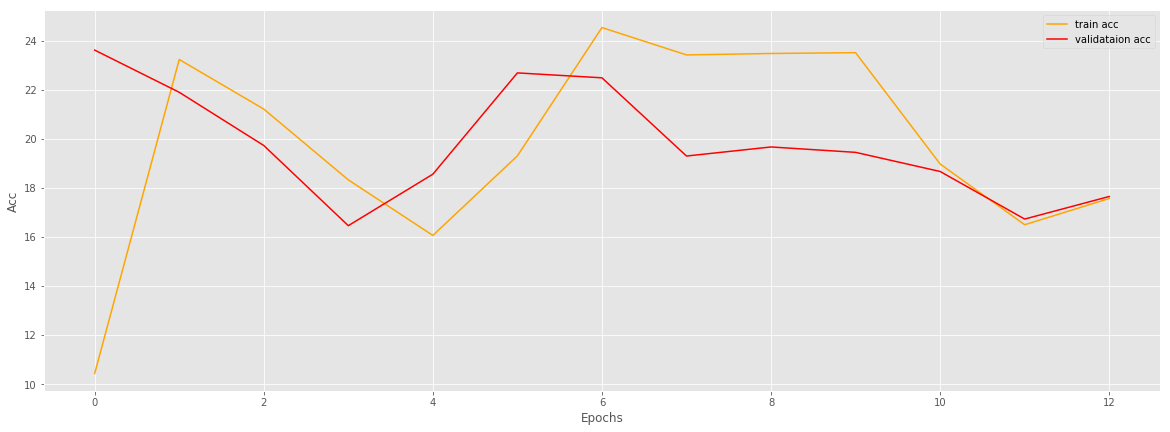

Max tr acc =  24.538333333333334
Max va acc =  23.62


In [19]:
tr_acc = result_df_tr_all.values[:,0].squeeze()
va_acc = result_df_va_all.values[:,0].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_acc, color='orange', label='train acc')
plt.plot(va_acc, color='red', label='validataion acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()
print("Max tr acc = ", np.max(tr_acc))
print("Max va acc = ", np.max(va_acc))

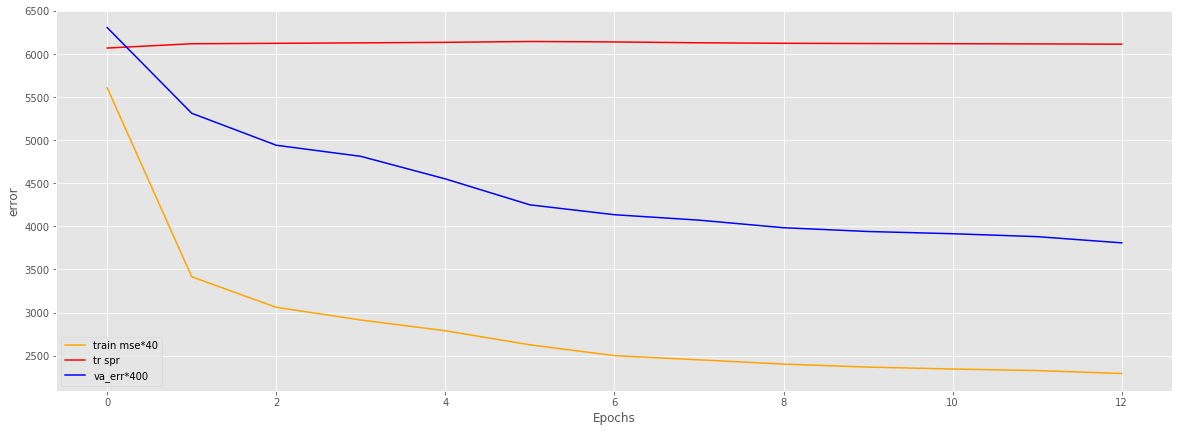

In [20]:
tr_mse_40 = 40*result_df_tr_all.values[:,3].squeeze()
tr_spr = result_df_tr_all.values[:,4].squeeze()
va_err_400 = 400*result_df_va_all.values[:,-1].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_mse_40, color='orange', label='train mse*40')
plt.plot(tr_spr, color='red', label='tr spr')
plt.plot(va_err_400, color='blue', label='va_err*400')
plt.xlabel('Epochs')
plt.ylabel('error')
plt.legend()
plt.show()